In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx

In [2]:
nodes_file = open(r'C:\Users\Fan\JupyterFile\ComplexNetwork\dataset\SpotifyArtistFeatureCollaborationNetwork\nodes.csv',encoding='utf_8')
edges_file = open(r'C:\Users\Fan\JupyterFile\ComplexNetwork\dataset\SpotifyArtistFeatureCollaborationNetwork\edges.csv',encoding='utf_8')
songs_file = open(r'C:\Users\Fan\JupyterFile\ComplexNetwork\dataset\SongsData\all_songs_data.csv',encoding='utf_8')
nodes = pd.read_csv(nodes_file)
edges = pd.read_csv(edges_file)
songs = pd.read_csv(songs_file)
nodes_file.close()
edges_file.close()
songs_file.close()

In [3]:
def merge_graphs(graph1, graph2):
    merged_graph = nx.Graph()
    merged_graph.add_nodes_from(graph1.nodes(data=True))  # 添加graph1的节点和属性
    merged_graph.add_edges_from(graph1.edges(data=True))  # 添加graph1的边和属性

    # 将graph2的节点和边添加到merged_graph
    merged_graph.add_nodes_from(graph2.nodes(data=True))
    merged_graph.add_edges_from(graph2.edges(data=True))

    return merged_graph

In [4]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import MWETokenizer
from nltk.corpus import wordnet
wnl = WordNetLemmatizer()
def get_word_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

stop_file = r'C:\Users\Fan\JupyterFile_310\stopwords.txt'
def English_word_cut(text):
    word_dict = {}
    t = text.lower()
    with open(stop_file, 'r') as file:
        custom_stopwords = [line.strip() for line in file.readlines()]
    default_stopwords = set(stopwords.words('english'))
    default_stopwords.update(custom_stopwords)

    wordlist = nltk.word_tokenize(t)
    filtered = [w for w in wordlist if w not in default_stopwords]
    filtered = [item for item in filtered if len(item) != 1]

    refiltered = nltk.pos_tag(filtered)

    lemmas_set = []
    for wordtag in refiltered:
        word, pos = wordtag
        wordnet_pos = get_word_pos(pos) or wordnet.NOUN
        if wordnet_pos in [wordnet.NOUN, wordnet.VERB]: # or pos in ['NNP', 'NNPS']:
            word = wnl.lemmatize(word, pos = wordnet_pos)
            lemmas_set.append(word)
            word_dict[word] = word_dict.get(word,0) + 1
    wordfreq = pd.DataFrame({'word':word_dict.keys(), 'freq':word_dict.values()})
    return lemmas_set
    
songs['clean_lyrics'] = songs['Lyrics'].astype(str).apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', str(x.lower())))
songs['filtered_words'] = songs['clean_lyrics'].apply(English_word_cut)
songs['word_counts'] = songs['filtered_words'].apply(lambda x: len(x))
songs.head(2)

,Album,Album URL,Artist,Featured Artists,Lyrics,Media,Rank,Release Date,Song Title,Song URL,Writers,Year,clean_lyrics,filtered_words,word_counts
0,Battle of New Orleans,https://genius.com/albums/Johnny-horton/Battle...,Johnny Horton,[],[Verse 1] In 1814 we took a little trip Along ...,[{'native_uri': 'spotify:track:0dwpdcQkeZqpuoA...,1,1959-04-01,The Battle Of New Orleans,https://genius.com/Johnny-horton-the-battle-of...,"[{'api_path': '/artists/561913', 'header_image...",1959.0,verse in we took a little trip along with co...,"[verse, trip, colonel, jackson, mighty, missis...",145
1,That’s All,https://genius.com/albums/Bobby-darin/That-s-all,Bobby Darin,[],"Oh the shark, babe Has such teeth, dear And he...",[{'native_uri': 'spotify:track:3E5ndyOfO6vFDEI...,2,NaN,Mack The Knife,https://genius.com/Bobby-darin-mack-the-knife-...,"[{'api_path': '/artists/218851', 'header_image...",1959.0,oh the shark babe has such teeth dear and he s...,"[shark, babe, teeth, dear, show, jackknife, ma...",86


In [5]:
artists_from_songs = set(songs['Artist'])
artists_from_nodes = set(nodes['name'])
artists = artists_from_songs & artists_from_nodes
top_songs = songs[songs['Artist'].isin(artists)]

top_artist_stats = top_songs.groupby('Artist').agg({'Artist':'count','word_counts':'mean'})
top_artist_stats.head()

,Artist,word_counts
Artist,,
.38 Special,1,107.000000
112,3,112.666667
2 Chainz,1,148.000000
21 Savage,2,307.000000
2Pac,6,224.166667


In [6]:
top_artist_stats.describe()

,Artist,word_counts
count,1046.000000,1046.000000
mean,3.084130,127.208106
std,3.631151,404.424546
min,1.000000,0.000000
25%,1.000000,64.562500
50%,2.000000,89.000000
75%,4.000000,130.875000
max,35.000000,12401.500000


In [7]:
import sys
top_nodes = nodes[nodes['name'].isin(artists)]

top_nodes_id = list(top_nodes['spotify_id'])
top_nodes_name = list(top_nodes['name'])

top_edges = edges[edges['id_0'].isin(top_nodes_id)]
top_edges = top_edges[edges['id_1'].isin(top_nodes_id)]

top_edges['name0'] = top_edges['id_0'].apply(lambda x: top_nodes_name[top_nodes_id.index(x)])
top_edges['name1'] = top_edges['id_1'].apply(lambda x: top_nodes_name[top_nodes_id.index(x)])
top_edges.head()

C:\Users\Fan\AppData\Local\Temp\ipykernel_20028\289764890.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top_edges = top_edges[edges['id_1'].isin(top_nodes_id)]


,id_0,id_1,name0,name1
18,2oX42qP5ineK3hrhBECLmj,6aZyMrc4doVtZyKNilOmwu,Andy Grammer,Colbie Caillat
111,55Aa2cqylxrFIXC767Z865,6LuN9FCkKOj5PcnpouEgny,Lil Wayne,Khalid
174,0hCNtLu0JehylgoiP8L4Gh,246dkjvS1zLTtiykXe5h60,Nicki Minaj,Post Malone
268,0a1gHP0HAqALbEyxaD5Ngn,6YHEMoNPbcheiWS2haGzkn,Rascal Flatts,Michael Bolton
409,5y2Xq6xcjJb2jVM54GHK3t,6JL8zeS1NmiOftqZTRgdTz,John Legend,Meghan Trainor


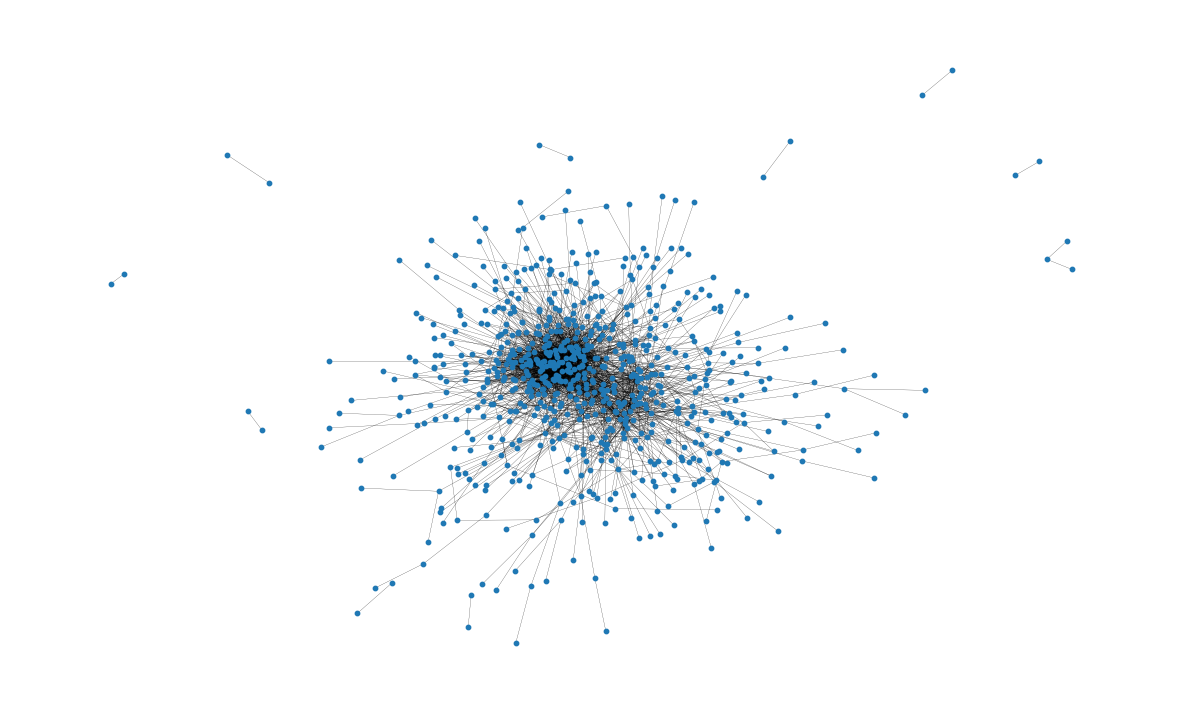

In [8]:
G = nx.from_pandas_edgelist(top_edges, 'name0', 'name1')

#egonet1 = merge_graphs(nx.ego_graph(G,'Shawn Mendes',radius=1),nx.ego_graph(G,'Taylor Swift',radius=1))
#egonet2 = merge_graphs(nx.ego_graph(G,'Sugarland',radius=1),nx.ego_graph(G,'Maren Morris',radius=1))
egonet1 = merge_graphs(nx.ego_graph(G,'Kenny Chesney',radius=1),nx.ego_graph(G,'Taylor Swift',radius=1))
egonet2 = merge_graphs(nx.ego_graph(G,'Tim McGraw',radius=1),nx.ego_graph(G,'Keith Urban',radius=1))
egonet = merge_graphs(egonet1,egonet2)
egonet_node_words = [top_artist_stats.loc[node]['word_counts'] for node in egonet.nodes()]
egonet_node_songs = [top_artist_stats.loc[node]['Artist']*100 for node in egonet.nodes()]

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

[]

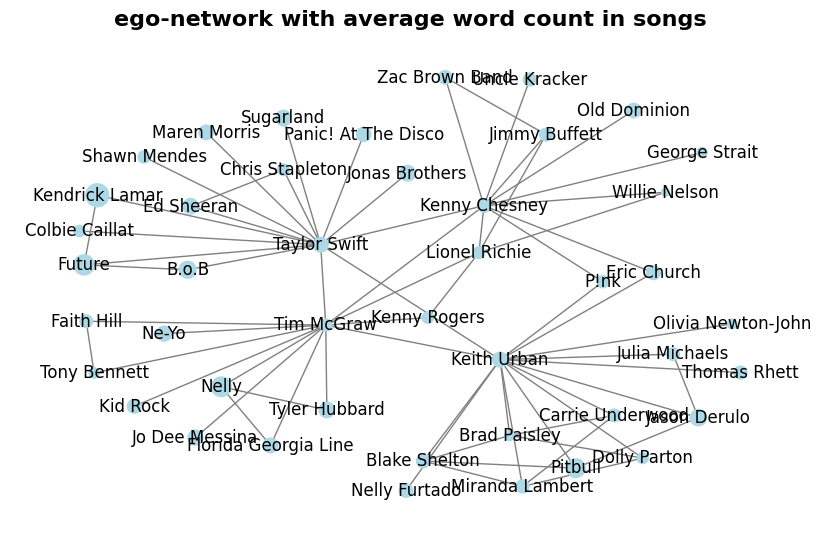

In [9]:
plt.figure(figsize=(8,5))
pos = nx.kamada_kawai_layout(egonet)
nx.draw(egonet, pos, with_labels=True, node_size=egonet_node_words, node_color='lightblue', edge_color='gray')
plt.title(f"ego-network with average word count in songs", fontsize=16, fontweight='bold')
plt.plot()

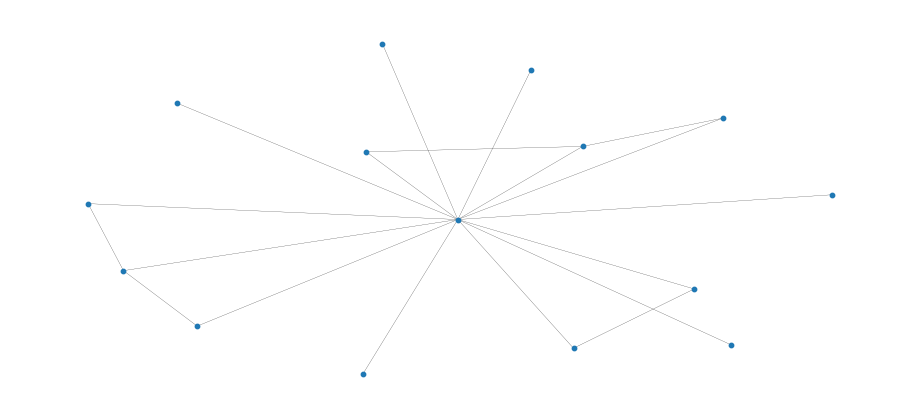

In [10]:
plt.figure(figsize=(9,4))
name = 'Taylor Swift'
ego_G = nx.ego_graph(G,name,radius=1)
pos = nx.spring_layout(ego_G,iterations=10, seed=123)
nx.draw(ego_G, pos = pos, **plot_options)

# 网络基本结构分析

节点数: 731
边数: 2793
网络密度: 0.010467927215486386
平均度: 7.641586867305062
平均聚集系数: 0.13129614088680955


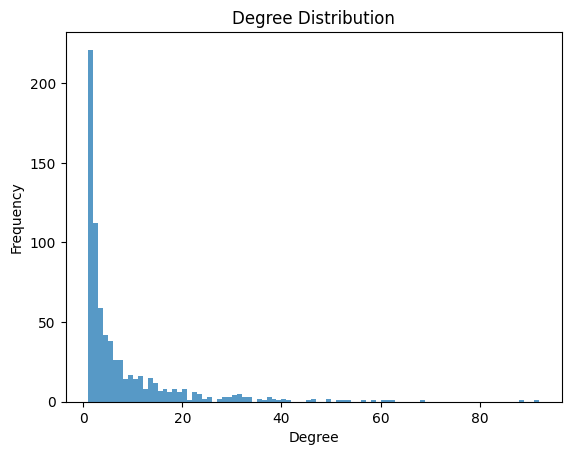

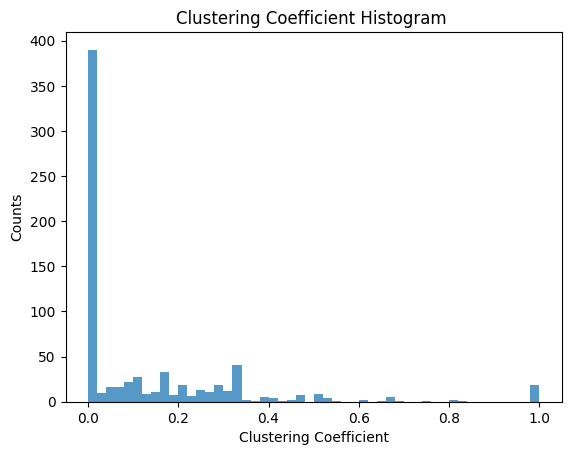

In [11]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
avg_degree = sum(dict(G.degree()).values()) / num_nodes
avg_cluster = nx.average_clustering(G)
print(f"节点数: {num_nodes}")
print(f"边数: {num_edges}")
print(f"网络密度: {density}")
print(f"平均度: {avg_degree}")
print(f"平均聚集系数: {avg_cluster}")
degrees = dict(G.degree())
plt.hist(degrees.values(), bins=range(min(degrees.values()), max(degrees.values())+1), alpha=0.75)
plt.title('Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()
plt.hist(nx.clustering(G).values(), bins=50, alpha=0.75)
plt.title("Clustering Coefficient Histogram ")
plt.xlabel("Clustering Coefficient")
plt.ylabel("Counts")
plt.show()

In [12]:
is_connected = nx.is_connected(G)

if is_connected:
    print("网络是连通的")
else:
    print("网络不是连通的")
    # 获取最大连通分量
    largest_component = max(nx.connected_components(G), key=len)
    subgraph = G.subgraph(largest_component)
    print(f"最大连通分量的大小: {len(largest_component)}")

网络不是连通的
最大连通分量的大小: 710


In [13]:
connected_components = list(nx.connected_components(G))

max_component = max(connected_components, key=len)
G_max = G.subgraph(max_component)
shortest_paths = nx.all_pairs_shortest_path_length(G_max)

total_length = 0
pair_count = 0
for u, paths in shortest_paths:
    for v, length in paths.items():
        if u != v:  # 排除节点对(u, u)
            total_length += length
            pair_count += 1

average_path_length = total_length / pair_count if pair_count > 0 else 0
print(f"最大连通部分的平均路径长度: {average_path_length}")

最大连通部分的平均路径长度: 3.729203996901011


In [14]:
degree_centrality = nx.degree_centrality(G)
top_5_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("度中心性最高的前5个歌手:", top_5_degree_centrality)

度中心性最高的前5个歌手: [('Snoop Dogg', 0.12602739726027398), ('Lil Wayne', 0.12054794520547946), ('Nicki Minaj', 0.09315068493150686), ('Chris Brown', 0.08493150684931507), ('T.I.', 0.08356164383561644)]


In [15]:
closeness_centrality = nx.closeness_centrality(G)
top_5_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("接近中心性最高的前5个歌手:", top_5_closeness)

接近中心性最高的前5个歌手: [('Snoop Dogg', 0.39965415530414455), ('Lil Wayne', 0.3855566123118931), ('Mary J. Blige', 0.3855566123118931), ('T.I.', 0.37546570860907363), ('Busta Rhymes', 0.36942280557351986)]


In [16]:
betweenness_centrality = nx.betweenness_centrality(G)
top_5_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("介数中心性最高的前5个歌手:", top_5_betweenness)

介数中心性最高的前5个歌手: [('Snoop Dogg', 0.12090120036774005), ('Elton John', 0.06039946763817074), ('Mary J. Blige', 0.057163866318063174), ('Lil Wayne', 0.05668395531333342), ('Dolly Parton', 0.052492774795572975)]


# PageRank

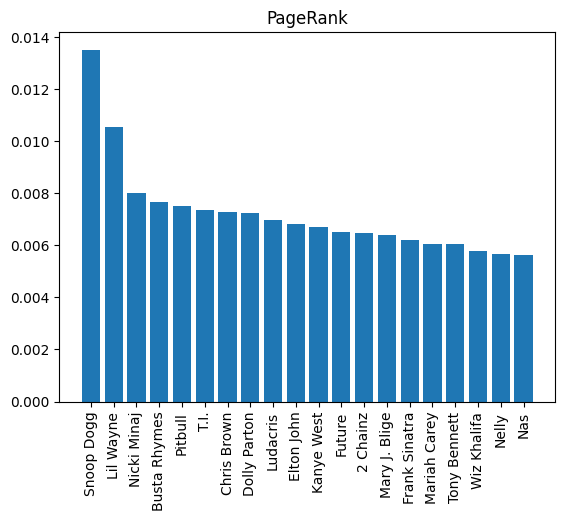

In [17]:
pagerank_scores = nx.pagerank(G)
pagerank_sort = sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[:20]
pagerank_sort_indexs = [x[0] for x in pagerank_sort]
pagerank_sort_values = [x[1] for x in pagerank_sort]
plt.bar(pagerank_sort_indexs,pagerank_sort_values)
plt.xticks(rotation=90)
plt.title('PageRank')
plt.show()

In [18]:
from networkx.algorithms.community import k_clique_communities
k = 3
communities = list(k_clique_communities(egonet, k))

for community in communities:
    print(community)

frozenset({'Kenny Chesney', 'Willie Nelson', 'Lionel Richie', 'Jimmy Buffett', 'Keith Urban', 'Taylor Swift', 'Tim McGraw', 'Zac Brown Band', 'Kenny Rogers'})
frozenset({'Faith Hill', 'Tony Bennett', 'Tim McGraw'})
frozenset({'Tim McGraw', 'Florida Georgia Line', 'Tyler Hubbard', 'Nelly'})
frozenset({'Ed Sheeran', 'Taylor Swift', 'Chris Stapleton'})
frozenset({'Taylor Swift', 'Future', 'Kendrick Lamar', 'B.o.B'})
frozenset({'Blake Shelton', 'Keith Urban', 'Miranda Lambert', 'Dolly Parton', 'Carrie Underwood', 'Brad Paisley', 'Jason Derulo', 'Pitbull', 'Julia Michaels'})


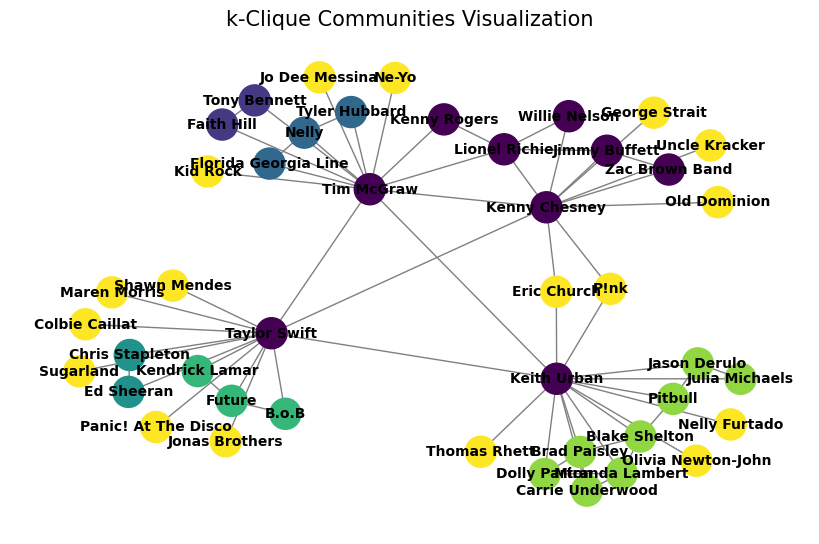

In [19]:
color_map = []
for node in egonet.nodes():
    for i, community in enumerate(communities):
        if node in community:
            color_map.append(i)
            break
        elif i+1 == len(communities):
            color_map.append(len(communities))
plt.figure(figsize=(8, 5))
nx.draw(egonet, with_labels=True, node_color=color_map, node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.title("k-Clique Communities Visualization", fontsize=15)
plt.show()

In [20]:
list_BTSego = list(egonet.nodes)
df_BTSego = top_songs[top_songs['Artist'].isin(list_BTSego)]
list_BTSego

['George Strait',
 'Kenny Chesney',
 'Old Dominion',
 'Willie Nelson',
 'Eric Church',
 'Lionel Richie',
 'Jimmy Buffett',
 'P!nk',
 'Taylor Swift',
 'Tim McGraw',
 'Uncle Kracker',
 'Zac Brown Band',
 'Jonas Brothers',
 'Chris Stapleton',
 'Panic! At The Disco',
 'Sugarland',
 'Maren Morris',
 'Ed Sheeran',
 'Shawn Mendes',
 'Kendrick Lamar',
 'Colbie Caillat',
 'Keith Urban',
 'Future',
 'B.o.B',
 'Faith Hill',
 'Ne-Yo',
 'Tony Bennett',
 'Kid Rock',
 'Nelly',
 'Jo Dee Messina',
 'Kenny Rogers',
 'Florida Georgia Line',
 'Tyler Hubbard',
 'Blake Shelton',
 'Nelly Furtado',
 'Pitbull',
 'Miranda Lambert',
 'Dolly Parton',
 'Carrie Underwood',
 'Brad Paisley',
 'Jason Derulo',
 'Thomas Rhett',
 'Olivia Newton-John',
 'Julia Michaels']

In [21]:
BTSego_songstats = df_BTSego.groupby('Artist').agg(
    song_count=('Song Title', 'size'),
    all_words=('filtered_words', lambda x: [word for sublist in x for word in sublist]),
    avg_word_count=('word_counts', 'mean')
)

In [22]:
index_BTSego = list(BTSego_songstats.index)
index_BTSego

['B.o.B',
 'Blake Shelton',
 'Brad Paisley',
 'Carrie Underwood',
 'Chris Stapleton',
 'Colbie Caillat',
 'Dolly Parton',
 'Ed Sheeran',
 'Eric Church',
 'Faith Hill',
 'Florida Georgia Line',
 'Future',
 'George Strait',
 'Jason Derulo',
 'Jimmy Buffett',
 'Jo Dee Messina',
 'Jonas Brothers',
 'Julia Michaels',
 'Keith Urban',
 'Kendrick Lamar',
 'Kenny Chesney',
 'Kenny Rogers',
 'Kid Rock',
 'Lionel Richie',
 'Maren Morris',
 'Miranda Lambert',
 'Ne-Yo',
 'Nelly',
 'Nelly Furtado',
 'Old Dominion',
 'Olivia Newton-John',
 'P!nk',
 'Panic! At The Disco',
 'Pitbull',
 'Shawn Mendes',
 'Sugarland',
 'Taylor Swift',
 'Thomas Rhett',
 'Tim McGraw',
 'Tony Bennett',
 'Tyler Hubbard',
 'Uncle Kracker',
 'Willie Nelson',
 'Zac Brown Band']

In [23]:
BTSego_songstats['text'] = BTSego_songstats['all_words'].apply(lambda x: ' '.join(x))
BTSego_songstats.head()

,song_count,all_words,avg_word_count,text
Artist,,,,
B.o.B,1,"[verse, drink, beer, cuban, cigar, head, shoul...",146.000000,verse drink beer cuban cigar head shoulder stu...
Blake Shelton,5,"[verse, leave, leave, say, mind, figure, shed,...",95.000000,verse leave leave say mind figure shed cuz tal...
Brad Paisley,1,"[remember, stare, night, meet, week, porch, mi...",52.000000,remember stare night meet week porch minute ki...
Carrie Underwood,6,"[verse, ive, bless, revelation, comin, guess, ...",83.833333,verse ive bless revelation comin guess time se...
Chris Stapleton,2,"[road, roll, mat, aint, kinda, plan, town, sta...",69.000000,road roll mat aint kinda plan town stand frien...


# LDA模型

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora

dictionary = corpora.Dictionary(BTSego_songstats['all_words'])

vectorizer = TfidfVectorizer(vocabulary=dictionary.token2id) 
tfidf = vectorizer.fit_transform(BTSego_songstats['text'])

In [25]:
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel

corpus = Sparse2Corpus(tfidf, documents_columns=False)

[(0,
  '0.002*"love" + 0.002*"baby" + 0.002*"chorus" + 0.001*"dont" + 0.001*"jonas" + 0.001*"say" + 0.001*"issue" + 0.001*"realize" + 0.001*"follow" + 0.001*"ill"'),
 (1,
  '0.001*"soak" + 0.001*"mexico" + 0.001*"rush" + 0.001*"sunlight" + 0.001*"pack" + 0.001*"slow" + 0.001*"bag" + 0.001*"foot" + 0.001*"ta" + 0.000*"suffer"'),
 (2,
  '0.002*"love" + 0.002*"chorus" + 0.001*"ta" + 0.001*"thats" + 0.001*"time" + 0.001*"dont" + 0.001*"verse" + 0.001*"hol" + 0.001*"leave" + 0.001*"say"'),
 (3,
  '0.003*"love" + 0.003*"chorus" + 0.003*"say" + 0.002*"yeah" + 0.002*"verse" + 0.002*"baby" + 0.002*"night" + 0.002*"time" + 0.002*"heart" + 0.002*"girl"')]

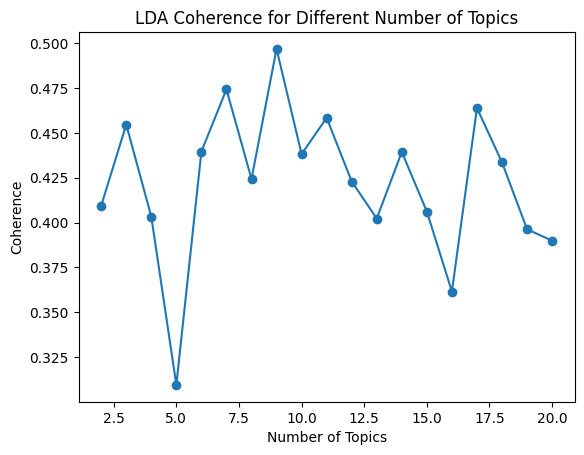

In [41]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
# 计算不同主题数的困惑度
topics_range = range(2, 21)
perplexities = []

for num_topics in topics_range:
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
    coherence = CoherenceModel(model=lda, texts=BTSego_songstats['all_words'], dictionary=dictionary, coherence='c_v')
    perplexities.append(coherence.get_coherence())

plt.plot(topics_range, perplexities, marker='o')
plt.title('LDA Coherence for Different Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.show()

Topic Exclusivity: [7.8634567, 7.862875, 7.854679, 7.642784, 7.85063, 7.8551188]


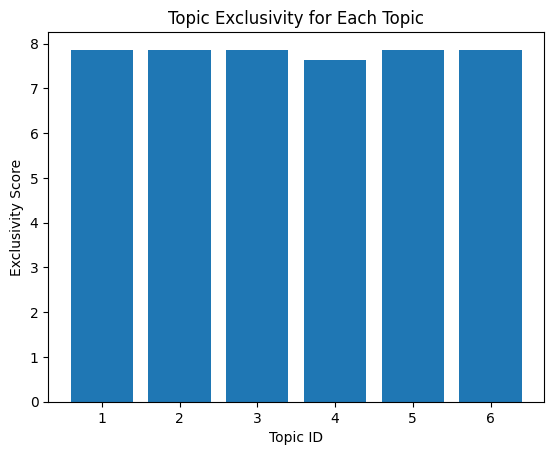

In [127]:
def calculate_exclusivity(lda_model):
    exclusivity_scores = []

    for topic_id in range(lda_model.num_topics):
        topic_dist = lda_model.get_topics()[topic_id]  # 这是一个 (词ID -> 词概率) 的分布
        entropy = -np.sum(topic_dist * np.log(topic_dist + 1e-10))
        exclusivity_scores.append(entropy)

    return exclusivity_scores
num_topics = 6
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20)
topic_exclusivity = calculate_exclusivity(lda)
print(f"Topic Exclusivity: {topic_exclusivity}")

# 可视化排他性指标
plt.bar(range(1, num_topics+1), topic_exclusivity)
plt.xlabel('Topic ID')
plt.ylabel('Exclusivity Score')
plt.title('Topic Exclusivity for Each Topic')
plt.show()

In [194]:
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=20)
lda.print_topics(-1)

[(0,
  '0.002*"issue" + 0.002*"da" + 0.001*"judge" + 0.001*"hop" + 0.001*"solo" + 0.001*"ra" + 0.001*"ei" + 0.001*"foot" + 0.001*"whatcha" + 0.001*"soak"'),
 (1,
  '0.002*"jonas" + 0.002*"holy" + 0.001*"hotel" + 0.001*"wicked" + 0.001*"stitch" + 0.001*"percocets" + 0.001*"thread" + 0.001*"smile" + 0.001*"joe" + 0.001*"mask"'),
 (2,
  '0.002*"whutooo" + 0.002*"stick" + 0.001*"band" + 0.001*"beat" + 0.001*"puttin" + 0.001*"knowoo" + 0.001*"paradise" + 0.001*"lane" + 0.001*"van" + 0.001*"jacket"'),
 (3,
  '0.001*"circle" + 0.001*"sweater" + 0.001*"startin" + 0.001*"bone" + 0.001*"cat" + 0.001*"rest" + 0.001*"fourleaf" + 0.001*"clover" + 0.001*"town" + 0.001*"record"'),
 (4,
  '0.007*"love" + 0.005*"chorus" + 0.005*"say" + 0.004*"baby" + 0.004*"verse" + 0.004*"dont" + 0.004*"time" + 0.004*"yeah" + 0.003*"see" + 0.003*"night"'),
 (5,
  '0.002*"woahohohoh" + 0.001*"fallin" + 0.001*"somebody" + 0.001*"realize" + 0.001*"woahohohohohohoh" + 0.001*"break" + 0.001*"applaud" + 0.001*"row" + 0.001*

In [195]:
from gensim.models import CoherenceModel
 
coherence = CoherenceModel(model=lda, texts=BTSego_songstats['all_words'], dictionary=dictionary, coherence='c_v')

print('Coherence Score: ', coherence.get_coherence())

Coherence Score:  0.43407796964105166


In [196]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Visualize the topics from LDA
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda, corpus, dictionary)
# pyLDAvis.display(vis)
pyLDAvis.save_html(vis,'ldaresult.html')

In [197]:
topic_mat = lda.get_document_topics(corpus)
num_topics = lda.num_topics
topic_vectors = np.zeros((len(topic_mat), num_topics))
i = 0
for topic_dist in topic_mat:
    for topic, prob in topic_dist:
        topic_vectors[i, topic] = prob
    i += 1
topic_vectors

array([[0.58780092, 0.01800041, 0.01797758, 0.01798219, 0.34026179,
        0.01797707],
       [0.01574175, 0.19666243, 0.01573848, 0.01575887, 0.74035996,
        0.01573852],
       [0.02679637, 0.02718866, 0.0267972 , 0.02680213, 0.86561841,
        0.02679719],
       [0.01393552, 0.01394212, 0.01393566, 0.01393864, 0.93031216,
        0.01393589],
       [0.02097467, 0.02097843, 0.02097885, 0.2373233 , 0.67877007,
        0.0209747 ],
       [0.02617757, 0.02619769, 0.02617752, 0.02618061, 0.65181333,
        0.24345325],
       [0.01895612, 0.38071638, 0.01895454, 0.01896371, 0.54345477,
        0.01895444],
       [0.01285218, 0.01285019, 0.01284431, 0.01283926, 0.93575692,
        0.01285719],
       [0.0212445 , 0.0212377 , 0.02122859, 0.02122797, 0.44446477,
        0.47059649],
       [0.02400857, 0.02407009, 0.02395823, 0.0239611 , 0.88004446,
        0.02395755],
       [0.0158073 , 0.37103856, 0.01578035, 0.01584255, 0.56575388,
        0.01577733],
       [0.01768083, 0

In [198]:
# Calculate topic similarity between artists in BTS' ego-network
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(topic_vectors)
similarity_matrix

array([[1.        , 0.50927333, 0.52905337, ..., 0.53571437, 0.53856848,
        0.51784554],
       [0.50927333, 1.        , 0.97392368, ..., 0.97511249, 0.97558541,
        0.9711193 ],
       [0.52905337, 0.97392368, 1.        , ..., 0.99986001, 0.99970963,
        0.99961261],
       ...,
       [0.53571437, 0.97511249, 0.99986001, ..., 1.        , 0.99997286,
        0.99900733],
       [0.53856848, 0.97558541, 0.99970963, ..., 0.99997286, 1.        ,
        0.99865201],
       [0.51784554, 0.9711193 , 0.99961261, ..., 0.99900733, 0.99865201,
        1.        ]])

In [219]:
G_BTSego_sim = nx.Graph()

for artist in index_BTSego:
    G_BTSego_sim.add_node(artist)

num_artists = len(index_BTSego)
for i in range(num_artists):
    for j in range(i + 1, num_artists):
        weight = similarity_matrix[i, j]
        if weight > 0.99:  # 相似度大于0.9则连接边
            G_BTSego_sim.add_edge(index_BTSego[i], index_BTSego[j], weight=weight)

[]

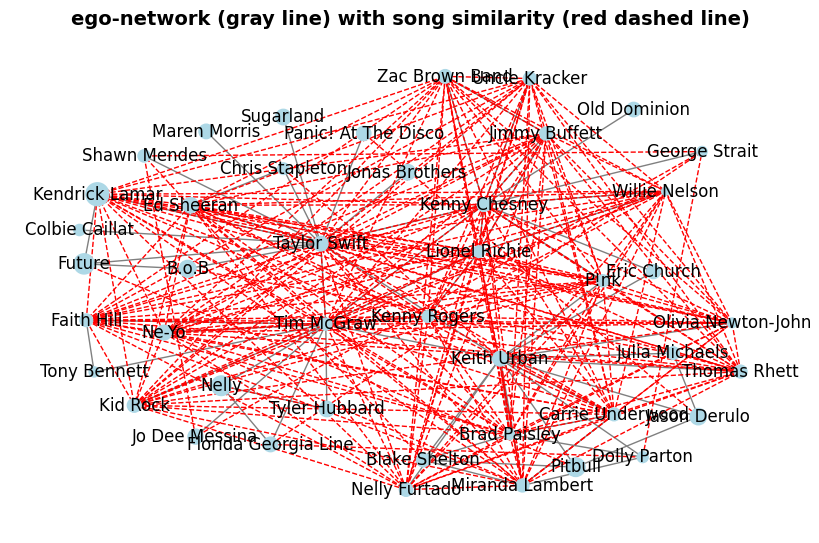

In [220]:
# Visualize ego network of BTS with song similarity between artists
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
pos = nx.kamada_kawai_layout(egonet)
nx.draw(egonet, pos, with_labels=True, node_size=egonet_node_words, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(G_BTSego_sim, pos, edge_color='red',style='dashed')
plt.title("ego-network (gray line) with song similarity (red dashed line)", fontsize=14, fontweight='bold')
plt.plot()

[]

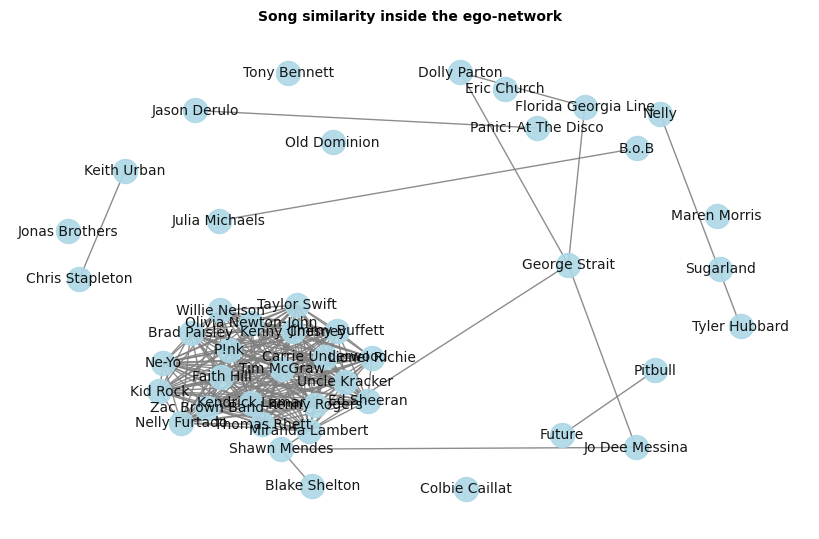

In [221]:
# Visualize song similarity (and their clusters) within the ego network of BTS
plt.figure(figsize=(8,5))
pos = nx.spring_layout(G_BTSego_sim,k=0.8,iterations=31,seed=8888)
nx.draw(G_BTSego_sim, pos, with_labels = True, alpha=0.9, font_size=10, node_color='lightblue', edge_color='gray')
plt.title("Song similarity inside the ego-network", fontsize=10, fontweight='bold')
plt.plot()

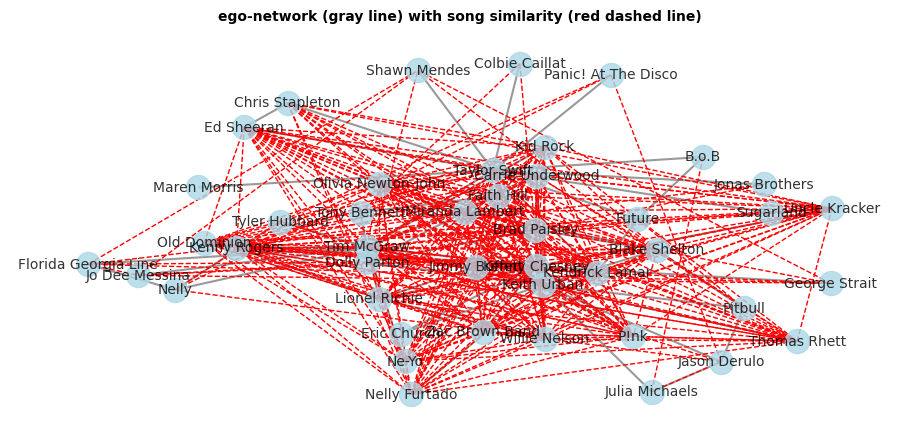

In [202]:
plt.figure(figsize=(9,4))
pos = nx.spring_layout(egonet,iterations=10, seed=8888)
nx.draw(egonet, pos = pos, with_labels = True, alpha=0.8, font_size=10, width = 1.5, node_color='lightblue', edge_color='gray')
nx.draw_networkx_edges(G_BTSego_sim, pos, edge_color='red',style='dashed', alpha=1, width = 1)
plt.title("ego-network (gray line) with song similarity (red dashed line)", fontsize=10, fontweight='bold')
plt.show()

In [34]:
num_nodes = egonet.number_of_nodes()
num_edges = egonet.number_of_edges()
density = nx.density(egonet)
avg_degree = sum(dict(egonet.degree()).values()) / num_nodes
avg_cluster = nx.average_clustering(ego_G)
print(f"节点数: {num_nodes}")
print(f"边数: {num_edges}")
print(f"网络密度: {density}")
print(f"平均度: {avg_degree}")
print(f"平均聚集系数: {avg_cluster}")

节点数: 44
边数: 67
网络密度: 0.0708245243128964
平均度: 3.0454545454545454
平均聚集系数: 0.4925518925518926


In [35]:
top_edges[top_edges['name0'].eq('Taylor Swift') + top_edges['name1'].eq('Taylor Swift')]

,id_0,id_1,name0,name1
2571,06HL4z0CvFAxyc27GXpf02,4YLtscXsxbVgi031ovDDdh,Taylor Swift,Chris Stapleton
21224,06HL4z0CvFAxyc27GXpf02,5ndkK3dpZLKtBklKjxNQwT,Taylor Swift,B.o.B
27587,06HL4z0CvFAxyc27GXpf02,7gOdHgIoIKoe4i9Tta6qdD,Taylor Swift,Jonas Brothers
33673,06HL4z0CvFAxyc27GXpf02,0u2FHSq3ln94y5Q57xazwf,Taylor Swift,Keith Urban
49781,06HL4z0CvFAxyc27GXpf02,20JZFwl6HVl6yg8a4H3ZqK,Taylor Swift,Panic! At The Disco
115307,06HL4z0CvFAxyc27GXpf02,1RyvyyTE3xzB2ZywiAwp0i,Taylor Swift,Future
131829,06HL4z0CvFAxyc27GXpf02,6eUKZXaKkcviH0Ku9w2n3V,Taylor Swift,Ed Sheeran
133464,06HL4z0CvFAxyc27GXpf02,6roFdX1y5BYSbp60OTJWMd,Taylor Swift,Tim McGraw
150559,06HL4z0CvFAxyc27GXpf02,3grHWM9bx2E9vwJCdlRv9O,Taylor Swift,Kenny Chesney
150821,06HL4z0CvFAxyc27GXpf02,0hYxQe3AK5jBPCr5MumLHD,Taylor Swift,Sugarland
